In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Sampler
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import deque
import urllib.request
import os
import copy
import hashlib

In [ ]:
import torch
import numpy as np
import random
import os

def set_seed(seed: int = 42):
    """设置随机种子以确保实验结果可重复"""
    # Python的随机数生成器
    random.seed(seed)
    # NumPy的随机数生成器
    np.random.seed(seed)
    # PyTorch的随机数生成器
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 用于多GPU的情况

    # 禁用cuDNN的非确定性算法
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # 设置环境变量
    os.environ['PYTHONHASHSEED'] = str(seed)

# 在实验开始时调用该函数
set_seed(42)

In [ ]:
# Import data
def load_data():
    #ijcnn1
    # train_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/ijcnn1.tr.bz2"
    # test_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/ijcnn1.t.bz2"

    # ##Download data
    # if not os.path.exists("ijcnn1.tr.bz2"):
    #     urllib.request.urlretrieve(train_url, "ijcnn1.tr.bz2")
    # if not os.path.exists("ijcnn1.t.bz2"):
    #     urllib.request.urlretrieve(test_url, "ijcnn1.t.bz2")

    # ##Load Data
    # X_train, y_train = load_svmlight_file("ijcnn1.tr.bz2")
    # X_test, y_test = load_svmlight_file("ijcnn1.t.bz2")

    ########gisette
    train_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2"
    test_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.t.bz2"

    # Download data
    if not os.path.exists("gisette_scale.tr.bz2"):
        urllib.request.urlretrieve(train_url, "gisette_scale.tr.bz2")
    if not os.path.exists("gisette_scale.t.bz2"):
        urllib.request.urlretrieve(test_url, "gisette_scale.t.bz2")

    # Load Data
    X_train, y_train = load_svmlight_file("gisette_scale.tr.bz2")
    X_test, y_test = load_svmlight_file("gisette_scale.t.bz2")


    # Transform data
    X_train, X_test = X_train.toarray(), X_test.toarray()
    y_train = np.where(y_train == -1, 0, y_train)
    y_test = np.where(y_test == -1, 0, y_test)


    # add biases term
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

    return (X_train, y_train), (X_test, y_test)

# 2. Data preparation
def create_neiboring_datasets(X, y, n_pairs):
    """creat neiboring dataset"""
    dataset_pairs = []

    for _ in range(n_pairs):
        # randomly choose 2 index
        idx1, idx2 = np.random.choice(len(X), 2, replace=False)

        X0 = np.delete(X, min(idx1,idx2), axis=0)
        X0 = np.delete(X0, max(idx1,idx2)-1, axis=0)
        y0 = np.delete(y, min(idx1,idx2))
        y0 = np.delete(y0, max(idx1,idx2)-1)

        # S1
        X1 = np.vstack([X0, X[idx1]])
        y1 = np.append(y0, y[idx1])

        # S2
        X2 = np.vstack([X0, X[idx2]])
        y2 = np.append(y0, y[idx2])

        dataset_pairs.append(((X1, y1), (X2, y2)))

    return dataset_pairs

# 3. Combined dataset
class CombinedDataset(TensorDataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, index):
        x1 = self.dataset1[index]
        x2 = self.dataset2[index]
        return x1, x2

    def __len__(self):
        return len(self.dataset1)

In [ ]:
# 3. Model for MSE loss
class LinearModel(nn.Module):
    """Linear model"""
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(input_dim, 2, bias=False)  # biases are contained already
        nn.init.constant_(self.fc.weight, 0.01)
    def forward(self, x):
        return self.fc(x).squeeze()

# 4. loss function
def mse_loss(pred, target):
    target = target.long()
    target = nn.functional.one_hot(target, num_classes=2).float()
    f = nn.MSELoss()
    return f(pred, target)


def hinge_loss(pred, target, q=1.5):
    """q-norm hinge loss"""
    target = target.long()
    target = nn.functional.one_hot(target, num_classes=2).float()
    margin = 1 - (2 * target - 1) * (2 * pred - 1)  # make sure the label values in [-1,1]
    loss = torch.clamp(margin, min=0) ** q
    return loss.mean()

In [ ]:
# 5. training
def train_dsgd(model1, model2, dataset1, dataset2, delay, lr, batch_size, test_data, interval, total_steps):
    """DSGD on neiboring dataset"""
    # 解包数据
    X1, y1 = dataset1
    X2, y2 = dataset2
    X_test, y_test = test_data

    # 转换为PyTorch张量
    tensor_x1 = torch.tensor(X1, dtype=torch.float32).to('cuda')
    tensor_y1 = torch.tensor(y1, dtype=torch.float32).to('cuda')
    tensor_x2 = torch.tensor(X2, dtype=torch.float32).to('cuda')
    tensor_y2 = torch.tensor(y2, dtype=torch.float32).to('cuda')
    test_x = torch.tensor(X_test, dtype=torch.float32).to('cuda')
    test_y = torch.tensor(y_test, dtype=torch.float32).to('cuda')

    # 创建DataLoader（使用相同的随机种子保证顺序一致)
    train_set1 = TensorDataset(tensor_x1, tensor_y1)
    train_set2 = TensorDataset(tensor_x2, tensor_y2)
    combined_set = CombinedDataset(train_set1, train_set2)
    train_loader = DataLoader(combined_set, batch_size=batch_size, shuffle=False)

    # 创建无限迭代器
    train_iter = iter(train_loader)

    # # 训练记录
    stability = []
    generalization_error1 = []
    generalization_error2 = []
    estimation_error1 =[]
    estimation_error2 =[]

    # # 初始化模型队列（存储历史权重）
    # queue1 = deque([copy.deepcopy(model1.state_dict()) for _ in range(delay+1)])
    # queue2 = deque([copy.deepcopy(model2.state_dict()) for _ in range(delay+1)])

    # # 优化器
    # optimizer1 = optim.SGD(model1.parameters(), lr=lr)
    # optimizer2 = optim.SGD(model2.parameters(), lr=lr)

    # # 临时模型用于计算延迟梯度
    # temp_model1 = LinearModel(X1.shape[1]).to('cuda')
    # temp_model2 = LinearModel(X2.shape[1]).to('cuda')

    # # 训练循环
    # for step in range(total_steps):
    #     # 获取下一个批次
    #     try:
    #         data = next(train_iter)
    #         batch_x1, batch_y1 = data[0]
    #         batch_x2, batch_y2 = data[1]
    #     except StopIteration:
    #         train_iter = iter(train_loader)
    #         data = next(train_iter)
    #         batch_x1, batch_y1 = data[0]
    #         batch_x2, batch_y2 = data[1]

    #     # 正确实现延迟SGD：
    #     # 1. 获取延迟权重（t-delay时刻的权重）
    #     delayed_weights1 = queue1.popleft()
    #     delayed_weights2 = queue2.popleft()


    #     # 2. 使用延迟权重计算梯度
    #     temp_model1.load_state_dict(delayed_weights1)
    #     temp_model2.load_state_dict(delayed_weights2)


    #     # if step % 50 ==0:
    #     #   w1 = model1.fc.weight.data.numpy().flatten()
    #     #   w2 = temp_model1.fc.weight.data.numpy().flatten()
    #     #   stab_value = np.linalg.norm(w1 - w2)
    #     #   print(stab_value)


    #     # 计算模型1的延迟梯度
    #     temp_model1.zero_grad()
    #     pred1 = temp_model1(batch_x1)
    #     loss1 = mse_loss(pred1, batch_y1)
    #     # loss1 = hinge_loss(pred1, batch_y1, q=1.5)
    #     loss1.backward()

    #     # 计算模型2的延迟梯度
    #     temp_model2.zero_grad()
    #     pred2 = temp_model2(batch_x2)
    #     loss2 = mse_loss(pred2, batch_y2)
    #     # loss2 = hinge_loss(pred2, batch_y2, q=1.5)
    #     loss2.backward()

    #     # 3. 用延迟梯度更新当前权重（t时刻的权重）
    #     optimizer1.zero_grad()
    #     # 将延迟梯度应用到当前模型
    #     for param, temp_param in zip(model1.parameters(), temp_model1.parameters()):
    #         if temp_param.grad is not None:
    #             param.grad = temp_param.grad.detach().clone()
    #     optimizer1.step()

    #     optimizer2.zero_grad()
    #     for param, temp_param in zip(model2.parameters(), temp_model2.parameters()):
    #         if temp_param.grad is not None:
    #             param.grad = temp_param.grad.detach().clone()
    #     optimizer2.step()

    #     # 4. 将更新后的权重加入队列（用于未来的延迟计算）
    #     queue1.append(copy.deepcopy(model1.state_dict()))
    #     queue2.append(copy.deepcopy(model2.state_dict()))


    # === 梯度存储队列 ===
    grad_queue1 = deque(maxlen=delay+1)  # 存储模型1的历史梯度
    grad_queue2 = deque(maxlen=delay+1)  # 存储模型2的历史梯度

    # 用零梯度填充初始队列
    for _ in range(delay+1):
        # 创建零梯度列表
        zero_grads1 = [torch.zeros_like(p) for p in model1.parameters()]
        zero_grads2 = [torch.zeros_like(p) for p in model2.parameters()]
        grad_queue1.append(zero_grads1)
        grad_queue2.append(zero_grads2)

    # 优化器（保持不变）
    optimizer1 = optim.SGD(model1.parameters(), lr=lr)
    optimizer2 = optim.SGD(model2.parameters(), lr=lr)

    # 训练循环
    for step in range(total_steps):
        # 获取下一个批次（保持不变）
        try:
            data = next(train_iter)
            batch_x1, batch_y1 = data[0]
            batch_x2, batch_y2 = data[1]
        except StopIteration:
            train_iter = iter(train_loader)
            data = next(train_iter)
            batch_x1, batch_y1 = data[0]
            batch_x2, batch_y2 = data[1]

        # === 模型1更新 ===
        # 1. 计算当前梯度（使用当前权重）
        optimizer1.zero_grad()
        pred1 = model1(batch_x1)
        loss1 = mse_loss(pred1, batch_y1)
        # loss1 = hinge_loss(pred1, batch_y1)
        loss1.backward()

        # 2. 存储当前梯度（完全隔离的副本）
        current_grads1 = []
        for param in model1.parameters():
            if param.grad is not None:
                # 创建完全隔离的梯度副本
                current_grads1.append(param.grad.detach().clone())
            else:
                current_grads1.append(torch.zeros_like(param))

        # 3. 将当前梯度加入队列
        grad_queue1.append(current_grads1)

        # 4. 获取延迟梯度（t-delay时刻的梯度）
        delayed_grads1 = grad_queue1.popleft()

        # 5. 应用延迟梯度更新模型
        optimizer1.zero_grad()
        for param, grad in zip(model1.parameters(), delayed_grads1):
            param.grad = grad.clone()  # 再次克隆确保隔离

        # 6. 执行更新
        optimizer1.step()

        # === 模型2更新 ===
        # 1. 计算当前梯度（使用当前权重）
        optimizer2.zero_grad()
        pred2 = model2(batch_x2)
        loss2 = mse_loss(pred2, batch_y2)
        # loss2 = hinge_loss(pred2, batch_y2)
        loss2.backward()

        # 2. 存储当前梯度（完全隔离的副本）
        current_grads2 = []
        for param in model2.parameters():
            if param.grad is not None:
                current_grads2.append(param.grad.detach().clone())
            else:
                current_grads2.append(torch.zeros_like(param))

        # 3. 将当前梯度加入队列
        grad_queue2.append(current_grads2)

        # 4. 获取延迟梯度（t-delay时刻的梯度）
        delayed_grads2 = grad_queue2.popleft()

        # 5. 应用延迟梯度更新模型
        optimizer2.zero_grad()
        for param, grad in zip(model2.parameters(), delayed_grads2):
            param.grad = grad.clone()  # 再次克隆确保隔离

        # 6. 执行更新
        optimizer2.step()

        # 定期测试
        if step % interval == 0:
            # 计算稳定性（权重差的L2范数）
            w1 = model1.fc.weight.data
            w2 = model2.fc.weight.data
            stab_value = torch.norm(w1 - w2).cpu()
            stability.append(stab_value)

            # 计算泛化误差（测试损失）
            with torch.no_grad():
                train_pred1 = model1(tensor_x1)
                train_loss1 = mse_loss(train_pred1, tensor_y1).item()
                # train_loss1 = hinge_loss(train_pred1, tensor_y1).item()
                train_pred2 = model2(tensor_x2)
                train_loss2 = mse_loss(train_pred2, tensor_y2).item()
                # train_loss2 = hinge_loss(train_pred2, tensor_y2).item()
                test_pred1 = model1(test_x)
                test_loss1 = mse_loss(test_pred1, test_y).item()
                # test_loss1 = hinge_loss(test_pred1, test_y).item()
                test_pred2 = model2(test_x)
                test_loss2 = mse_loss(test_pred2, test_y).item()
                # test_loss2 = hinge_loss(test_pred2, test_y).item()

            generalization_error1.append(test_loss1)
            generalization_error2.append(test_loss2)
            estimation_error1.append(train_loss1)
            estimation_error2.append(train_loss2)
            # estimation_error1.append(test_loss1 - train_loss1)
            # estimation_error2.append(test_loss2 - train_loss2)
        if step % (100*interval) == 0:
            print(f"Step {step:4d} | Stability: {stab_value:.6f} | "
                  f"Tra Error (Model1): {train_loss1:.6f} | "
                  f"Gen Error (Model1): {test_loss1:.6f} | "
                  f"Est Error (Model1): {test_loss1 - train_loss1:.6f} | ")

    return stability, generalization_error1, generalization_error2, estimation_error1, estimation_error2

In [ ]:
# 6. main
def main_experiment():
    # 加载数据
    (X_train, y_train), (X_test, y_test) = load_data()
    input_dim = X_train.shape[1]
    print(f"Data loaded: train={len(X_train)}, test={len(X_test)}, features={input_dim}")

    # 实验参数
    n_pairs = 10  # 相邻数据集对数
    delays = [0, 10, 20, 30, 80]  # 延迟因子
    batch_size = 32
    lr = 1e-5
    interval = 3  # 测试间隔
    total_steps = 6000  # 总训练步数

    # 创建相邻数据集对
    dataset_pairs = create_neiboring_datasets(X_train, y_train, n_pairs)
    print(f"Created {len(dataset_pairs)} pairs of adjacent datasets")

    # 存储结果
    results = {d: {'stability': [], 'gen_error': []} for d in delays}

    # 对每个延迟进行实验
    for delay in delays:
        print(f"\n=== Running experiments with delay={delay} ===")

        stability_results = []
        gen_error_results = []
        est_error_results = []

        # 对每对数据集进行实验
        for i, (ds1, ds2) in enumerate(dataset_pairs):
            print(f"Training on dataset pair {i+1}/{len(dataset_pairs)}")

            # 初始化模型
            model1 = LinearModel(input_dim).to('cuda')
            model2 = LinearModel(input_dim).to('cuda')

            # 确保两个模型初始权重相同
            model2.load_state_dict(model1.state_dict())

            # 训练
            stability, gen_error1, gen_error2, est_error1, est_error2 = train_dsgd(
                model1, model2, ds1, ds2, delay, lr, batch_size,
                (X_test, y_test), interval, total_steps
            )

            # 存储结果
            stability_results.append(stability)
            # 取两个模型的泛化误差平均值
            # avg_gen_error = [(g1 + g2)/2 for g1, g2 in zip(gen_error1, gen_error2)]
            gen_error_results.append(gen_error1)
            # avg_est_error = [(e1 + e2)/2 for e1, e2 in zip(est_error1, est_error2)]
            est_error_results.append(est_error1)

        # 保存该延迟的所有结果
        results[delay]['stability'] = stability_results
        results[delay]['gen_error'] = gen_error_results
        results[delay]['est_error'] = est_error_results

    return results

In [ ]:
def visualize_results(results, interval):
    # 设置水平排列的子图（1行3列），调整figsize适应水平布局
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))  # 宽度增加以适应水平排列

    # 使用适合色盲的配色方案
    colors = plt.cm.tab10.colors

    # 按delay从大到小排序，确保小delay的折线显示在最上层
    sorted_delays = sorted(results.keys(), reverse=True)

    # 绘制稳定性结果
    for i, delay in enumerate(sorted_delays):
        data = results[delay]
        stability_data = np.array(data['stability'])
        gen_error_data = np.nan_to_num(stability_data, nan = 1000)
        mean_stab = np.mean(stability_data, axis=0)
        std_stab = np.std(stability_data, axis=0)

        steps = np.arange(len(mean_stab)) * interval
        ax1.plot(steps, mean_stab, label=str(delay), color=colors[i % len(colors)], linewidth=1)
        ax1.fill_between(steps,
                         mean_stab - 0.25*std_stab,
                         mean_stab + 0.25*std_stab,
                         alpha=0.2, color=colors[i % len(colors)])

    ax1.set_title('Algorithm Stability', fontsize=14)
    ax1.set_xlabel('Training Steps', fontsize=12)
    ax1.set_ylabel('Algorithmic Stability', fontsize=12)
    ax1.legend(title='Delays', fontsize=9, loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_ylim(bottom=0)

    # 绘制泛化误差结果
    for i, delay in enumerate(sorted_delays):
        data = results[delay]
        if delay == 80:
            continue

        gen_error_data = np.array(data['gen_error'])
        gen_error_data = np.nan_to_num(gen_error_data, nan = 1000)
        mean_gen = np.mean(gen_error_data, axis=0)
        std_gen = np.std(gen_error_data, axis=0)

        steps = np.arange(len(mean_gen)) * interval
        ax2.plot(steps, mean_gen, label=str(delay), color=colors[i % len(colors)], linewidth=1)
        ax2.fill_between(steps,
                         mean_gen - 0.25*std_gen,
                         mean_gen + 0.25*std_gen,
                         alpha=0.2, color=colors[i % len(colors)])

    ax2.set_title('Generalization Error (Test Loss)', fontsize=14)
    ax2.set_xlabel('Training Steps', fontsize=12)
    ax2.set_ylabel('Population Risk', fontsize=12)
    ax2.legend(title='Delays', fontsize=9, loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.6)
    # ax2.set_ylim(bottom=0.15, top=0.4)  # 保持原有的y轴范围设置

    # 绘制估计误差结果
    for i, delay in enumerate(sorted_delays):
        data = results[delay]
        if delay == 80:
            continue

        est_error_data = np.array(data['est_error'])
        est_error_data = np.nan_to_num(est_error_data, nan = 1000)
        mean_est = np.mean(est_error_data, axis=0)
        std_est = np.std(est_error_data, axis=0)

        steps = np.arange(len(mean_est)) * interval
        ax3.plot(steps, mean_est, label=str(delay), color=colors[i % len(colors)], linewidth=1)
        ax3.fill_between(steps,
                         mean_est - 0.25*std_est,
                         mean_est + 0.25*std_est,
                         alpha=0.2, color=colors[i % len(colors)])

    ax3.set_title('Estimation Error (Test Loss - Train Loss)', fontsize=14)
    ax3.set_xlabel('Training Steps', fontsize=12)
    ax3.set_ylabel('Estimation Error', fontsize=12)
    ax3.legend(title='Delays', fontsize=9, loc='upper right')
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.set_ylim(bottom=0)

    # 自动调整y轴上限
    # for ax in [ax1, ax2, ax3]:
    #     y_data = np.concatenate([line.get_ydata() for line in ax.lines])
    #     if len(y_data) > 0:
    #         ax.set_ylim(top=y_data.max() * 1.1)

    # 保持ax2的自定义范围（如果需要覆盖自动调整）
    # ax1.set_ylim(bottom=0, top=4e-3)
    # ax2.set_ylim(bottom=0.1, top=0.6)
    # ax3.set_ylim(bottom=-0.01, top=0.03)

    plt.tight_layout()  # 自动调整布局，避免标签重叠
    # 保存图片：提高dpi至600，使用无损压缩格式，确保边界完整
    # plt.savefig('/content/drive/MyDrive/DelayedSGD/ijcnn1_hinge_stability_results.png',
    #             dpi=600,  # 高分辨率，适合印刷或高清显示
    #             bbox_inches='tight',  # 去除多余空白
    #             pad_inches=0.1,  # 保留少量边距
    #             format='png')  # PNG格式支持高dpi且无损
    plt.show()


Data loaded: train=6000, test=1000, features=5001
Created 10 pairs of adjacent datasets

=== Running experiments with delay=0 ===
Training on dataset pair 1/10
Step    0 | Stability: 0.000000 | Tra Error (Model1): 1462.652954 | Gen Error (Model1): 1463.971436 | Est Error (Model1): 1.318481 | 
Step  300 | Stability: 0.000039 | Tra Error (Model1): 0.938557 | Gen Error (Model1): 0.959700 | Est Error (Model1): 0.021144 | 
Step  600 | Stability: 0.000105 | Tra Error (Model1): 0.717747 | Gen Error (Model1): 0.744894 | Est Error (Model1): 0.027146 | 
Step  900 | Stability: 0.000131 | Tra Error (Model1): 0.559286 | Gen Error (Model1): 0.575496 | Est Error (Model1): 0.016210 | 
Step 1200 | Stability: 0.000181 | Tra Error (Model1): 0.443489 | Gen Error (Model1): 0.460417 | Est Error (Model1): 0.016928 | 
Step 1500 | Stability: 0.000202 | Tra Error (Model1): 0.359443 | Gen Error (Model1): 0.381707 | Est Error (Model1): 0.022265 | 
Step 1800 | Stability: 0.000241 | Tra Error (Model1): 0.297339 | G

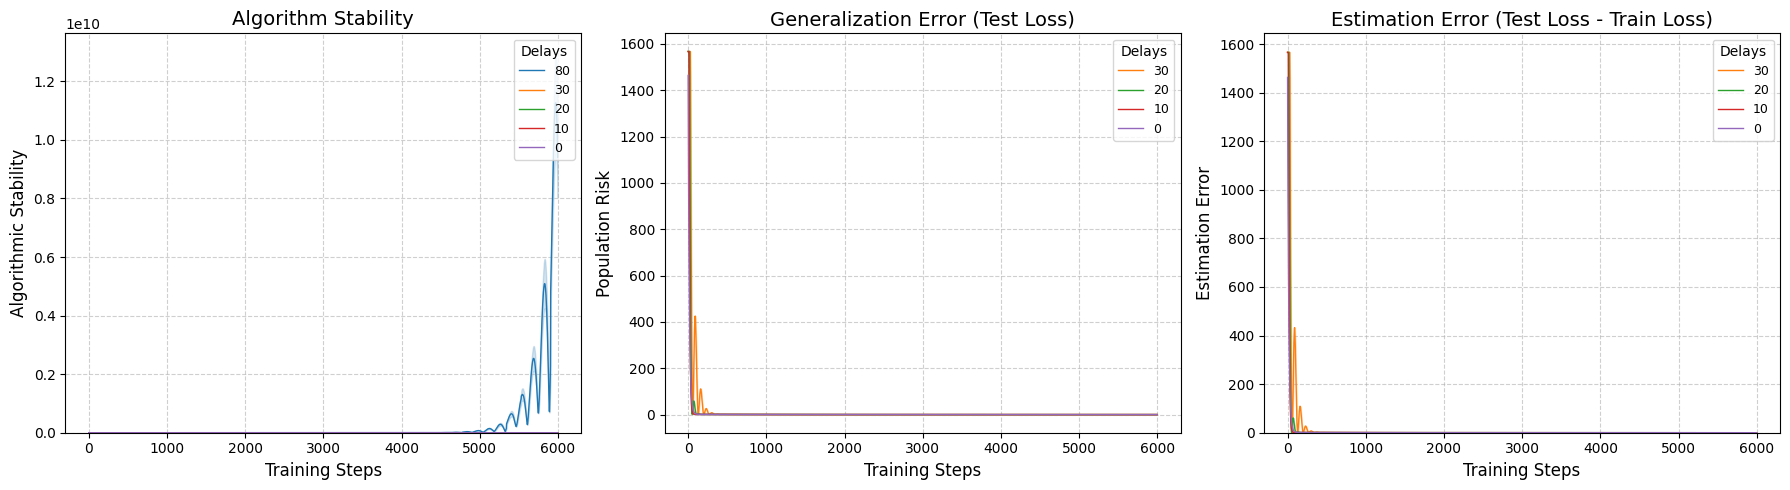

In [ ]:
import gc
gc.collect()
# 执行实验
if __name__ == "__main__":
    set_seed(42) #42
    results = main_experiment()
    # torch.save(results,"/content/drive/MyDrive/DelayedSGD/gisette_pairs10_bs32_lr5e-6_itr6000_tau010203080.pt")
    visualize_results(results, interval=3)

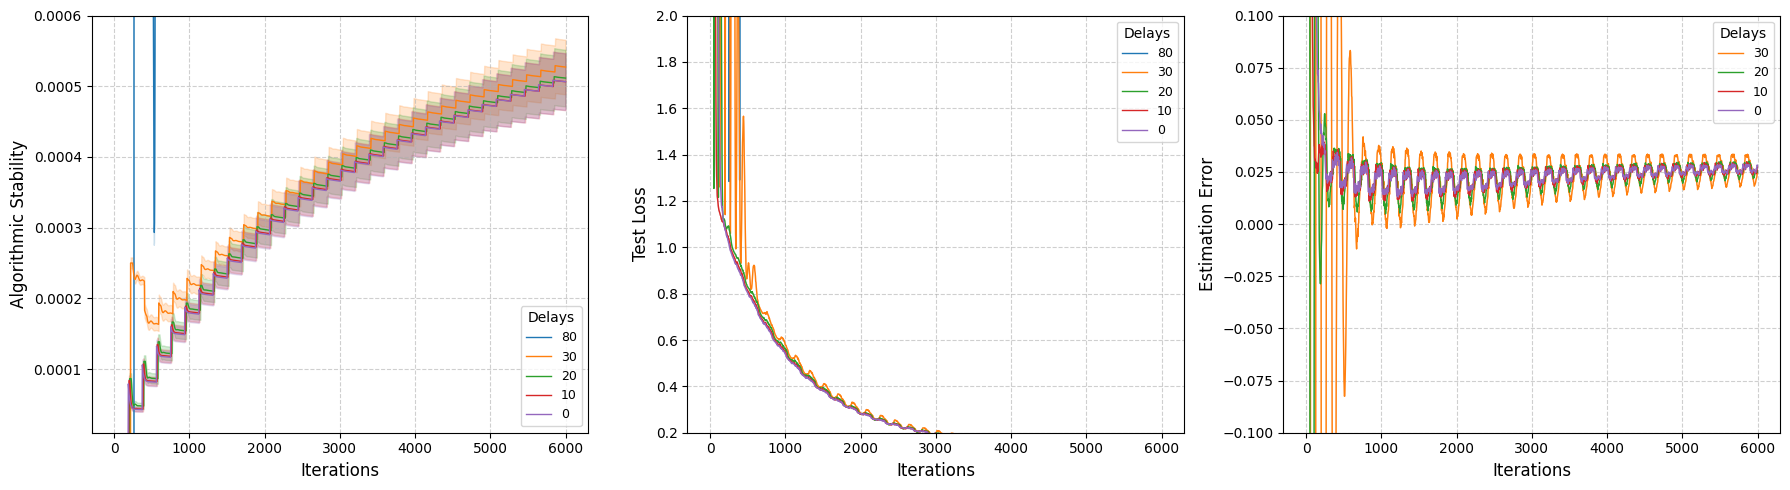

In [ ]:
def visualize_results(results, interval):
    # 设置水平排列的子图（1行3列），调整figsize适应水平布局
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))  # 宽度增加以适应水平排列

    # 使用适合色盲的配色方案
    colors = plt.cm.tab10.colors

    # 按delay从大到小排序，确保小delay的折线显示在最上层
    sorted_delays = sorted(results.keys(), reverse=True)

    # 绘制稳定性结果
    for i, delay in enumerate(sorted_delays):
        data = results[delay]
        stability_data = np.array(data['stability'])
        gen_error_data = np.nan_to_num(stability_data, nan = 1000)
        mean_stab = np.mean(stability_data, axis=0)
        std_stab = np.std(stability_data, axis=0)

        steps = np.arange(len(mean_stab)) * interval
        ax1.plot(steps, mean_stab, label=str(delay), color=colors[i % len(colors)], linewidth=1)
        ax1.fill_between(steps,
                         mean_stab - 0.25*std_stab,
                         mean_stab + 0.25*std_stab,
                         alpha=0.2, color=colors[i % len(colors)])

    # ax1.set_title('Algorithm Stability', fontsize=14)
    ax1.set_xlabel('Iterations', fontsize=12)
    ax1.set_ylabel('Algorithmic Stability', fontsize=12)
    ax1.legend(title='Delays', fontsize=9, loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_ylim(bottom=0)

    # 绘制泛化误差结果
    for i, delay in enumerate(sorted_delays):
        data = results[delay]
        if delay == 81:
            continue

        gen_error_data = np.array(data['gen_error'])
        gen_error_data = np.nan_to_num(gen_error_data, nan = 1000)
        mean_gen = np.mean(gen_error_data, axis=0)
        std_gen = np.std(gen_error_data, axis=0)

        steps = np.arange(len(mean_gen)) * interval
        ax2.plot(steps, mean_gen, label=str(delay), color=colors[i % len(colors)], linewidth=1)
        ax2.fill_between(steps,
                         mean_gen - 0.25*std_gen,
                         mean_gen + 0.25*std_gen,
                         alpha=0.2, color=colors[i % len(colors)])

    # ax2.set_title('Generalization Error (Test Loss)', fontsize=14)
    ax2.set_xlabel('Iterations', fontsize=12)
    ax2.set_ylabel('Test Loss', fontsize=12)
    ax2.legend(title='Delays', fontsize=9, loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.6)
    # ax2.set_ylim(bottom=0.15, top=0.4)  # 保持原有的y轴范围设置

    # 绘制估计误差结果
    for i, delay in enumerate(sorted_delays):
        data = results[delay]
        if delay == 80:
            continue

        est_error_data = np.array(data['gen_error']) - np.array(data['est_error'])
        est_error_data = np.nan_to_num(est_error_data, nan = 1000)
        # print(est_error_data.shape)
        mean_est = np.mean(est_error_data, axis=0)
        std_est = np.std(est_error_data, axis=0)

        steps = np.arange(len(mean_est)) * interval
        ax3.plot(steps, mean_est, label=str(delay), color=colors[i % len(colors)], linewidth=1)
        ax3.fill_between(steps,
                         mean_est - 0.25*std_est,
                         mean_est + 0.25*std_est,
                         alpha=0.2, color=colors[i % len(colors)])

    # ax3.set_title('Estimation Error (Test Loss - Train Loss)', fontsize=14)
    ax3.set_xlabel('Iterations', fontsize=12)
    ax3.set_ylabel('Estimation Error', fontsize=12)
    ax3.legend(title='Delays', fontsize=9, loc='upper right')
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.set_ylim(bottom=0)

    # 自动调整y轴上限
    # for ax in [ax1, ax2, ax3]:
    #     y_data = np.concatenate([line.get_ydata() for line in ax.lines])
    #     if len(y_data) > 0:
    #         ax.set_ylim(top=y_data.max() * 1.1)

    # 保持ax2的自定义范围（如果需要覆盖自动调整）
    ax1.set_ylim(bottom=0.00001, top=0.0006)
    ax2.set_ylim(bottom=0.2, top=2)
    ax3.set_ylim(bottom=-0.1, top=0.1)
    # ax3.set_ylim(bottom=-0.1, top=0.1)

    plt.tight_layout()  # 自动调整布局，避免标签重叠
    # 保存图片：提高dpi至600，使用无损压缩格式，确保边界完整
    # plt.savefig('/content/drive/MyDrive/DelayedSGD/gisette_hinge_0729_results_010203080.png',
    #             dpi=600,  # 高分辨率，适合印刷或高清显示
    #             bbox_inches='tight',  # 去除多余空白
    #             pad_inches=0.1,  # 保留少量边距
    #             format='png')  # PNG格式支持高dpi且无损
    plt.show()

# results_test = torch.load("/content/drive/MyDrive/DelayedSGD/gisette_pairs10_bs32_lr5e-6_itr6000_tau010203080.pt")
visualize_results(results, interval=3)

In [ ]:
results = torch.load("/content/drive/MyDrive/DelayedSGD/gisette_pairs10_bs32_lr5e-6_itr6000_tau010203080.pt")

for i, delay in enumerate(results):
  data = results[delay]
  stability_data = np.array(data['stability'])
  gen_error_data = np.array(data['gen_error'])
  print(stability_data.shape())
  mean_stab = np.mean(stability_data, axis=0)
  mean_gen = np.mean(gen_error_data, axis=0)
  print(i)
  for i in (1+np.arange(6))*333:
    print("stability", mean_stab[i])
    print("test loss", mean_gen[i])

KeyboardInterrupt: 